### 以下代码用来实现经典的编码器－解码器代码，并使用 cmn_eng　2.2w条中英文翻译数据，作为实例
如果希望更详细的解读，强烈推荐阅读：https://zhuanlan.zhihu.com/p/28054589
https://leovan.me/cn/2018/10/seq2seq-and-attention-machanism/

In [1]:
!pip install sklearn

Looking in indexes: https://mirrors.aliyun.com/pypi/simple


In [2]:
import tensorflow as tf
import os

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

# 修复中文显示问题
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
print(tf.__version__)

# 判断是否gpu可用,如果可用设置gpu使用显存
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

2.0.0


In [4]:
import unicodedata
import re
import numpy as np
import os
import io
import time

In [5]:
with open('./data/cmn-eng.txt', 'r', encoding='utf-8') as f:
    contexts = f.readlines()
contexts[10]

'Got it?\t你懂了吗？\n'

In [6]:
def data_pro(contexts):
    processed_contexts_en = []
    processed_contexts_ch = []
    for line in contexts:
        en, ch = re.split(r'\t', line.strip())
        # 如果句子过长，则跳过此句
#         if len(ch) > 100:
#             continue
#         print(en, ch)
        en = re.sub(r'([\?\.\!\,¿])', r' \1', en)
#         print(en)
        en = re.sub(r'\s+', ' ', en)
        ch = re.sub(r'\s+', ' ', ch)
        en = re.sub(r'[^a-zA-Z\?\.\!\,。？！，、¿]+', r' ', en)
        ch = re.sub(r'[^a-zA-Z\?\.\!\,。？！，、¿\u4e00-\u9fa5]+', r' ', ch)
        en = '<start> ' + en[:200] + ' <end>'
        ch = '<start> ' + ' '.join([i for i in ch[:100]]) + ' <end>'
        
        processed_contexts_en.append(en)
        processed_contexts_ch.append(ch)
    
    return processed_contexts_en, processed_contexts_ch


processed_contexts_en, processed_contexts_ch = data_pro(contexts)

In [7]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [8]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [9]:
def load_dataset():
    # 创建清理过的输入输出对
    input_tensor, inp_lang_tokenizer = tokenize(processed_contexts_en)
    target_tensor, targ_lang_tokenizer = tokenize(processed_contexts_ch)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [10]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset()
input_tensor[-1], target_tensor[-1]
inp_lang.texts_to_sequences(['<start> hello world <end>', 'head of'])
targ_lang.texts_to_sequences(['<start> 你 好 世 界 <end>', '你 好']), targ_lang.index_word[1]

([[1, 7, 34, 352, 515, 2], [7, 34]], '<start>')

In [11]:
# 计算目标张量的最大长度 （max_length）
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [12]:
# 采用 80 - 20 的比例切分训练集和验证集
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.15)

# 显示长度
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

18763 18763 3312 3312


In [13]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [14]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
45 ----> will
4 ----> i
91 ----> see
7 ----> you
117 ----> tomorrow
9 ----> ?
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
4 ----> 我
91 ----> 明
24 ----> 天
36 ----> 能
182 ----> 见
26 ----> 到
7 ----> 你
48 ----> 吗
13 ----> ？
2 ----> <end>


In [15]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 256
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [16]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([256, 38]), TensorShape([256, 46]))

#### 本编码器采用 Bahdanau 注意力
p(y_i | y_1,..., y_{i-1}, x) = g(y_{i-1}, s_i, c_i)

s_i = f (s_{i-1}, y_{i-1}, c_i)    # 即 s_i与 s_{i-1} , y_{i-1}, c_i 有关, c_i 是 attention 计算得来


In [17]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.enc_units = enc_units
        self.batch_sz = batch_sz
        # 返回隐状态 和 整个输出序列
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True, return_state=True, 
                                       recurrent_initializer='glorot_uniform')
    
    def call(self, x, hidden):
        # x形状为 (batch_size, seq_len)
        # hidden 为初始化向量,形状为 (batch_size, units_dim)
        em = self.embedding_dim(x)
        output, state = self.gru(em, initial_state = hidden)
        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [18]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# 初始化一个样本输入隐向量
sample_hidden = encoder.initialize_hidden_state()
print(sample_hidden)

sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('input shape: (batch size, sequence length) {}'.format(example_input_batch.shape))
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(256, 1024), dtype=float32)
input shape: (batch size, sequence length) (256, 38)
Encoder output shape: (batch size, sequence length, units) (256, 38, 1024)
Encoder Hidden state shape: (batch size, units) (256, 1024)


In [19]:
# attention 实现的是输入两个向量，输出　上下文向量　和　权重，其中权重主要是为了后续 方便　可视化使用,那么，BahdanauAttention中：
# Ci = reduce_sum(α * Hs)，　αij = exp(eij) / reduce_sum(exp(eij)), eij = v.tanh(w.s + w.h)
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        """
        # 初始化需要训练的参数 eij = v.tanh(w.s + w.h)，乘相当于dense操作
        """
        super(BahdanauAttention, self).__init__()
        self.Ws = tf.keras.layers.Dense(units)
        self.Wh = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, query, values):
        """
        输入: query, values,即S_t-1, hidden_ts
        输出: context_vec, attention_weights
        """
        # 这里根据使用方法，query 是 Si中的一个
        query = tf.expand_dims(query, axis=1)
        # eij = v.tanh(w.s + w.h) 这个式子比较特别，需要使用广播机制
        # w . S -> （batch_size, 1, units）, W . h -> (batch_size, seq_len, units)满足广播机制，且 score —> (batch_size, seq_len, 1)
        score = self.V(tf.tanh(self.Ws(query) + self.Wh(values)))
        # 计算 权重 attention_weight 形状 (batch_size, seq_len, 1)，在 seqence 方向上 转换概率值，所以 axis = 1
        attention_weights = tf.nn.softmax(score, axis=1)
        # 计算 content_vector,沿着 axis=1的方向求和
        context_vec = tf.reduce_sum(attention_weights * values, axis=1)
    
        return context_vec, attention_weights

In [20]:
# attention 实现的是输入两个向量，输出　上下文向量　和　权重，其中权重主要是为了后续 方便　可视化使用,那么，BahdanauAttention中：
# Ci = reduce_sum(α * Hs)，　αij = exp(eij) / reduce_sum(exp(eij)), eij = v.tanh(w.s + w.h)
class BahdanauAttention2(tf.keras.layers.Layer):
    def __init__(self, units):
        """
        # 初始化需要训练的参数 eij = v.tanh(w.s + w.h)，乘相当于dense操作
        """
        super(BahdanauAttention2, self).__init__()
        self.units = units
        
    def build(self, input_shape):
        # 注意这里使用了 build 方法,其主要用于根据input_shape创建 layer的Variable
        self.Ws = tf.Variable(tf.random.normal(shape=(input_shape[-1],units),stddev=0.01,mean=0,dtype=tf.float32))
        self.Wh = tf.Variable(tf.random.normal(shape=(input_shape[-1],units),stddev=0.01,mean=0,dtype=tf.float32))
        self.V = tf.Variable(tf.random.normal(shape=(input_shape[-1],1),stddev=0.01,mean=0,dtype=tf.float32))

    def call(self, query, values):
        """
        输入: query, values,即S_t-1, hidden_ts
        输出: context_vec, attention_weights
        """
        query = tf.expand_dims(query, axis=1)
        score = (tf.tanh(query @ self.Ws + values @ self.Wh)) @ self.V
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vec = tf.reduce_sum(attention_weights * values, axis=1)

        return context_vec, attention_weights

In [21]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

print(attention_weights[0])  # 可以看出，没有经过训练的网络，权重参数是比较均衡的

Attention result shape: (batch size, units) (256, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (256, 38, 1)
tf.Tensor(
[[0.02653692]
 [0.02648555]
 [0.02629445]
 [0.02648648]
 [0.02666861]
 [0.02680712]
 [0.02670638]
 [0.02647925]
 [0.02624538]
 [0.0264552 ]
 [0.02625991]
 [0.02619459]
 [0.02618651]
 [0.02619937]
 [0.02621639]
 [0.02623092]
 [0.02624122]
 [0.02624765]
 [0.0262512 ]
 [0.0262529 ]
 [0.02625353]
 [0.02625361]
 [0.02625347]
 [0.02625328]
 [0.0262531 ]
 [0.02625297]
 [0.02625288]
 [0.02625284]
 [0.02625282]
 [0.02625281]
 [0.02625281]
 [0.02625282]
 [0.02625283]
 [0.02625284]
 [0.02625285]
 [0.02625285]
 [0.02625286]
 [0.02625286]], shape=(38, 1), dtype=float32)


In [22]:
# decoder 输入和输出是什么？ decoder是逐个解码，所以，输入是 x -> (batch_size, 1), decoder侧的隐向量 hidden -> (batch_size, dec_units)
# 输出是 下一个状态的隐向量 state 及 output,以及为了方便打印的 attention_weights

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size    # 词表大小
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)    # 词嵌入维度
        self.dec_units = dec_units    # 解码器 gru的矩阵的维度，即 hidden_size大小
        self.gru = tf.keras.layers.GRU(dec_units, return_sequences=True, 
                                       return_state=True, recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        # 逐个计算 x,hidden,enc_output计算得到的权重计算后的 context_vec 和 attention_weight
        context_vec, attention_weights = self.attention(hidden, enc_output)
        # x的维度是 batch_size * 1，经过 embedding 后的维度为 (batch_sz, 1, embedding_size)
        x = self.embedding(x)
        # 拼接 x 和 context_vec，得到 (batch_size, 1, hidden_size+embedding_dim)
        x = tf.concat([tf.expand_dims(context_vec, 1), x], axis=-1)
        # 然后将 x 输入到 gru 中
        output, state = self.gru(x, initial_state=hidden)
        # # dense输入可以为2维,也可以为3维，dense会自动在 time_step维度上展开,所以考虑输出后的维度为2维，先进行维度转换
        output = tf.reshape(output, (-1, output.shape[2]))
        # 输出形状 (batch_size, vocab_size)
        x = self.fc(output)
        
        return x, state, attention_weights

In [23]:
# 简单测试
decoder = Decoder(vocab_tar_size, embedding_dim, units)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (256, 3407)


### 定义优化器和损失函数

In [24]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    # 计算mask
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

# loss的计算方式

In [25]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)
tf.train.Checkpoint()

In [26]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    # encoder的最后输出隐状态作为 decoder 初始输入隐状态
    dec_hidden = enc_hidden
    # 使用 <start> 做初始解码输入
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # 教师强制 - 将目标词作为下一个输入
    for t in range(1, targ.shape[1]):    # 逐个输入
      # 将编码器输出 （enc_output） 传送至解码器
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # 使用教师强制，预测阶段正常解码应该用 predictions 作为下一个 time_step 的输入
      dec_input = tf.expand_dims(targ[:, t], 1)
  # 平均 batch_loss
  batch_loss = (loss / int(targ.shape[0]))
  # 总的可训练参数:
  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [27]:
EPOCHS = 50

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # 每 2 个周期（epoch），保存（检查点）一次模型
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.3501
Epoch 1 Loss 0.2306
Time taken for 1 epoch 114.55030298233032 sec

Epoch 2 Batch 0 Loss 0.2081
Epoch 2 Loss 0.1894
Time taken for 1 epoch 66.3093376159668 sec

Epoch 3 Batch 0 Loss 0.1747
Epoch 3 Loss 0.1657
Time taken for 1 epoch 64.68755269050598 sec

Epoch 4 Batch 0 Loss 0.1505
Epoch 4 Loss 0.1468
Time taken for 1 epoch 66.84205842018127 sec

Epoch 5 Batch 0 Loss 0.1336
Epoch 5 Loss 0.1309
Time taken for 1 epoch 61.34873175621033 sec

Epoch 6 Batch 0 Loss 0.1104
Epoch 6 Loss 0.1163
Time taken for 1 epoch 67.26499199867249 sec

Epoch 7 Batch 0 Loss 0.1032
Epoch 7 Loss 0.1024
Time taken for 1 epoch 63.76023817062378 sec

Epoch 8 Batch 0 Loss 0.0920
Epoch 8 Loss 0.0895
Time taken for 1 epoch 65.85333108901978 sec

Epoch 9 Batch 0 Loss 0.0766
Epoch 9 Loss 0.0772
Time taken for 1 epoch 64.53484678268433 sec

Epoch 10 Batch 0 Loss 0.0641
Epoch 10 Loss 0.0660
Time taken for 1 epoch 66.5434992313385 sec

Epoch 11 Batch 0 Loss 0.0545
Epoch 11 Loss 0.0555
Time take

### 翻译
评估函数类似于训练循环，不同之处在于在这里我们不使用 `教师强制`。每个时间步的解码器输入是其先前的预测、隐藏层状态和编码器输出。
当模型预测 结束标记 时停止预测。
存储 每个时间步的注意力权重。
请注意：对于一个输入，编码器输出仅计算一次。

In [28]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    inputs = inp_lang.texts_to_sequences([sentence])
    print('inputs', inputs)
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 存储注意力权重以便后面制图
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 预测的 ID 被输送回模型
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [29]:
# 注意力权重制图函数
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [30]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

### 恢复最新的检查点并验证

In [31]:
# 恢复检查点目录 （checkpoint_dir） 中最新的检查点
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

inputs [[1, 1800, 363, 22, 15, 358, 3, 2]]
Input: <start> hello world , it great . <end>
Predicted translation: 你 讀 了 ， 很 多 錢 。 <end> 


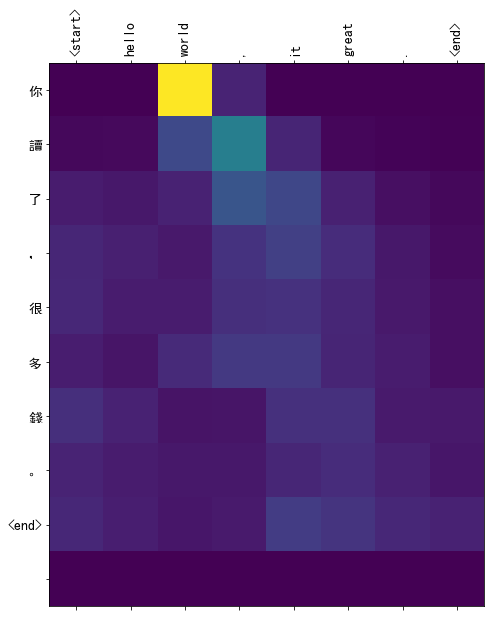

In [32]:
translate('<start> hello world , it great . <end>')

inputs [[1, 1273, 251, 22, 7, 33, 358, 122, 2]]
Input: <start> hey boy , you are great ! <end>
Predicted translation: 老 ， 你 们 是 新 的 。 <end> 


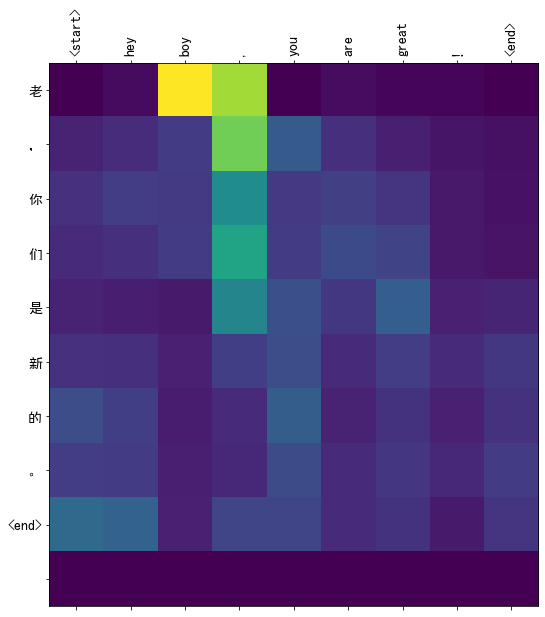

In [33]:
translate('<start> hey boy , you are great ! <end>')

inputs [[1, 51, 1375, 7, 33, 122, 2]]
Input: <start> how lucky you are ! <end>
Predicted translation: 你 們 倆 嗎 ？ <end> 


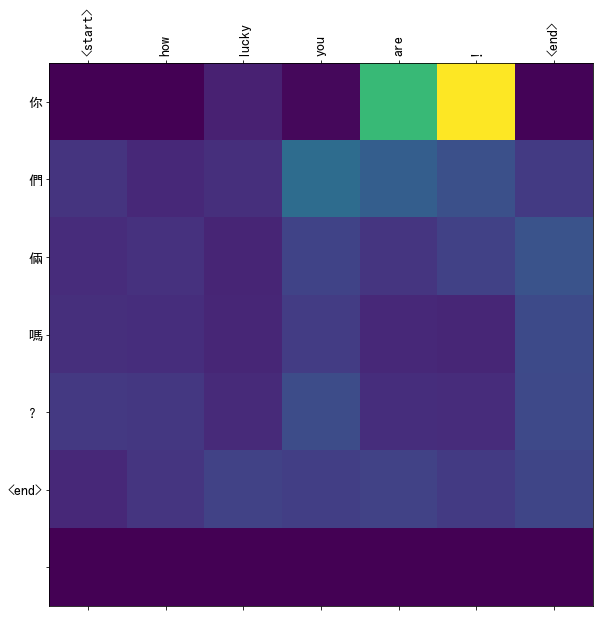

In [34]:
translate('<start> how lucky you are ! <end>')